# SVM - Climate Sentiment Multiclass Classification
## CS522 Project

### Dataset: 
https://www.kaggle.com/code/luiskalckstein/climate-sentiment-multiclass-classification

### Imports

In [1]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
%matplotlib inline

# Our base common modules
from Common.DataCenter import data_center
from Common.preprocessor import text_preprocessing_tfidf, one_hot_encoding
from Common.UtilFuncs import print_evaluation, Evaluator, Lab

# Denoising Methodes
import Common.IsolationForestMethod as IsolationForestMethod
import Common.ConfidentLearningMethod as ConfidentLearningMethod
import Common.LocalOutlierFactorMethod as LocalOutlierFactorMethod



### Run SVM

In [2]:
# parameter:  vectorised X and encoded y of training set and test set
def run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec):
    # Run SVM - fit and predict
    SVM             = OneVsRestClassifier(LinearSVC(dual=False, class_weight='balanced'), n_jobs=-1)
    SVM.fit(X_train_vec, y_train_vec)
    y_pred          = SVM.predict(X_test_vec)
    return  y_pred



### Do an experiment

In [3]:
# do an experiment without denoising
# Parameter: original X,y of training set and test set
# Return evaluation info
def do_experiment(train_df, test_df):
    X_train, y_train = data_center.Xy(train_df)
    X_test, y_test   = data_center.Xy(test_df)
    
    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing_tfidf(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    # Run SVM and evaluate the results
    y_pred = run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec)

    # Print the evaluation
    print_evaluation(y_test_vec, y_pred, labels=[0,1,2,3])
    evaluateDF = Evaluator.do_evaluate(y_test_vec, y_pred)
    return evaluateDF


### Main entry
**The settings of the noise sources.**

In [4]:
# Each item: source -> (size, distribution)
noisy_set_sizes = {
    'mislabeled' : (8600, None),                   # max size: 15000
    'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    'translated' : (8600, "reserve_labels"),       # max size: 5000
}


**Choose a experiment without denoising**

In [5]:
# Each item: name -> (funcion, whether choose) note:only the first active one will be used
experiment_without_denoising = {
    'SVM without denoising' : (do_experiment, 1),
}


**Choose a experiment with denoising**

In [6]:
# Each item: name -> (funcion, whether choose) note:only the first active one will be used
experiment_with_denoising = {
    'Confident Learning' : (ConfidentLearningMethod.do_experiment_with_denoising_for_SVM,   0),
    'Isolation Forest'   : (IsolationForestMethod.do_experiment_with_denoising_for_SVM,     0),
    'LocalOutlierFactor' : (LocalOutlierFactorMethod.do_experiment_with_denoising_for_SVM,  1),
}


**The training set of each experiment**

In [7]:
origin_train_set_sizes = [2000, 4000, 5000, 8000, 10000, 15000, 20000]
noisy_train_set_sizes  = [(4000, 1000), (8000, 2000), (15000, 5000)]


**Initialize the lab, which will run a serial of experiments.<br>
Split the database into training set, test set, noisy set, validation set.**

In [8]:
lab = Lab("twitter_sentiment_data_clean.csv", noisy_sources = noisy_set_sizes, total_train_size = 20000, total_test_size = 4000)


**Review the summary of the whole data**

In [9]:
lab.dc.print_summary()


###################################### Data Summary #############################################
  Original set size: 40908
      sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
  Training set size: 20000
  Test set size: 4000
  Noisy set size: 25800
  Validation set size: 1000
      noise sources ('mislabeled', 'irrelevant', 'translated'): 33.3%, 33.3%, 33.3%
##################################################################################################


**To see the data features via a demo**

In [10]:
train_df = lab.dc.get_train_with_noisy_df(15000,5000)
data_center.print_data(train_df.head(15))


,noise,noise_text,sentiment,origin(sentiment),tweetid...,message...
0,1,mislabeled,3,2,8108306943,Regional/Global seabird stress
1,0,none,2,-,9536174384,I have to write an essay over
2,1,mislabeled,1,3,8645926535,Barack Obama warns climate cha
3,0,none,2,-,8199736905,RT @mitskileaks: want to speci
4,0,none,2,-,8438476460,.@RepBrianFitz Thank you for a
5,0,none,2,-,8182648187,RT @billmckibben: Reading clim
6,0,none,2,-,9556340417,RT @LanreShaper: 'Africa contr
7,1,mislabeled,3,1,9587601354,Keilmuan itu politik. Hawong N
8,0,none,2,-,8401717188,RT @WRIClimate: @CNBC He shoul
9,0,none,0,-,8254569694,@magslol global warming is a C


**Calculate the filename for save the lab**

In [11]:
lab_filename = Lab.get_active_experiment_name(experiment_with_denoising)
if lab_filename is None:
    lab_filename  = Lab.get_active_experiment_name(experiment_without_denoising)
if lab_filename is None:
    print("Nothing to do.")
    exit(0)
lab_filename = "saving/" + lab_filename + str(noisy_train_set_sizes) + ".pk"
    

# Run new experiments (or just review the evaluations saved by previous experiments)

In [12]:
RUN = 1
if RUN:     # Run new experiments
    # Set the function to classify data without denoising
    lab.set_experiment_no_denoising(experiment_without_denoising)

    # Set the function to classify data with denoising
    lab.set_experiment_with_denoising(experiment_with_denoising)

    print("-------------- No noisy training sets ----------")
    lab.do_batch_experiments(origin_train_set_sizes)

    print("-------------- Noisy training sets -------------")
    lab.do_batch_experiments(noisy_train_set_sizes)

    # Save the evaluations of lab
    lab.save(lab_filename)

else:       # Load evaluations saved by previous experiments
    lab = Lab.load(lab_filename)


-------------- No noisy training sets ----------
* 1> Training set size: 2000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.349, 0.315, 0.711, 0.678]
    micro_f1: 0.626 , macro_f1: 0.513 , weighted_f1: 0.597, macro_precision: 0.592, macro_recall: 0.504
* 2> Training set size: 4000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.442, 0.371, 0.741, 0.695]
    micro_f1: 0.657 , macro_f1: 0.562 , weighted_f1: 0.635, macro_precision: 0.623, macro_recall: 0.554
* 3> Training set size: 5000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.466, 0.4, 0.746, 0.709]
    micro_f1: 0.668 , macro_f1: 0.580 , weighted_f1: 0.648, macro_precision: 0.636, macro_recall: 0.570
* 4> Training set size: 8000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.521, 0.42, 0.758, 0.719]
  

# Show evaluations

,Origin,Noise,Denoised,Micro F1,Macro F1,Weighted F1,Macro Precision,Macro Recall,F1 of classes,Sentiments distribution,Noise sources distribution
Experiment,,,,,,,,,,,
1,2000,0,-,0.625651,0.513415,0.597445,0.591622,0.503592,"[0.349, 0.315, 0.711, 0.678]","[9.4%, 18.3%, 50.2%, 22.1%]",-
2,4000,0,-,0.657229,0.562267,0.634902,0.623003,0.553626,"[0.442, 0.371, 0.741, 0.695]","[9.4%, 18.3%, 50.2%, 22.1%]",-
3,5000,0,-,0.667753,0.580286,0.648046,0.636269,0.569531,"[0.466, 0.4, 0.746, 0.709]","[9.4%, 18.3%, 50.2%, 22.1%]",-
4,8000,0,-,0.682283,0.604498,0.665412,0.647677,0.597741,"[0.521, 0.42, 0.758, 0.719]","[9.4%, 18.3%, 50.2%, 22.1%]",-
5,10000,0,-,0.689442,0.614399,0.673934,0.645478,0.613033,"[0.534, 0.431, 0.765, 0.727]","[9.4%, 18.3%, 50.2%, 22.1%]",-
6,15000,0,-,0.701889,0.633075,0.687961,0.657390,0.636509,"[0.567, 0.452, 0.774, 0.74]","[9.4%, 18.3%, 50.2%, 22.1%]",-
7,20000,0,-,0.716268,0.654099,0.705114,0.668449,0.660337,"[0.599, 0.483, 0.788, 0.746]","[9.4%, 18.3%, 50.2%, 22.1%]",-
8,4000,1000,N,0.635449,0.553179,0.621547,0.597319,0.531767,"[0.432, 0.378, 0.718, 0.685]","[11.7%, 19.5%, 46.3%, 22.6%]","[34.0%, 32.6%, 33.4%]"
9,8000,2000,N,0.661885,0.592878,0.652298,0.625172,0.574682,"[0.492, 0.433, 0.737, 0.71]","[11.8%, 19.4%, 46.2%, 22.6%]","[33.8%, 33.1%, 33.1%]"


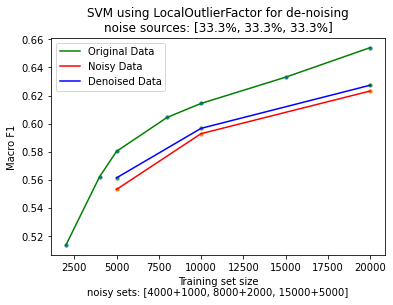

In [13]:
# In a form
lab.print()

# In a plot
lab.plot()
